<a href="https://colab.research.google.com/github/atwine/my_first_GAN/blob/master/My_first_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adverserial Network

This is my first implementation.

The dataset I am using if from: https://github.com/zalandoresearch/fashion-mnist

We can also just download and upload the data if you have a good internet connection

In [3]:
##let's load the libraries that we will need 
from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import sys
import numpy as np

Using TensorFlow backend.


In [0]:
#helper class
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1 #the images we are going to use are black and white.
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 10 #we initialize the noise that the generator takes in.

        optimizer = Adam(0.0002, 0.5) #the optimizer we are going to work with

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(2048))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=64, sample_interval=50):

        # Load the dataset
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

        # Rescale -1 to 1
        x_train = x_train / 127.5 - 1.
        x_train = np.expand_dims(x_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            imgs = x_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.645394, acc.: 42.19%] [G loss: 0.484876]


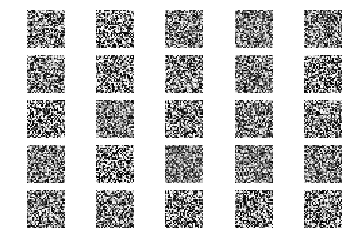

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.614791, acc.: 54.69%] [G loss: 0.482023]
2 [D loss: 0.565672, acc.: 53.12%] [G loss: 0.519987]
3 [D loss: 0.566649, acc.: 57.81%] [G loss: 0.610680]
4 [D loss: 0.477055, acc.: 64.06%] [G loss: 0.704594]
5 [D loss: 0.455028, acc.: 64.06%] [G loss: 0.719252]
6 [D loss: 0.473810, acc.: 59.38%] [G loss: 0.800354]
7 [D loss: 0.414356, acc.: 68.75%] [G loss: 0.875210]
8 [D loss: 0.390175, acc.: 71.88%] [G loss: 0.979801]
9 [D loss: 0.335044, acc.: 82.81%] [G loss: 1.074153]
10 [D loss: 0.257079, acc.: 92.19%] [G loss: 1.148890]
11 [D loss: 0.269747, acc.: 90.62%] [G loss: 1.207865]
12 [D loss: 0.242642, acc.: 95.31%] [G loss: 1.338039]
13 [D loss: 0.192665, acc.: 100.00%] [G loss: 1.381766]
14 [D loss: 0.245123, acc.: 93.75%] [G loss: 1.460154]
15 [D loss: 0.183093, acc.: 100.00%] [G loss: 1.623645]
16 [D loss: 0.190185, acc.: 96.88%] [G loss: 1.653738]
17 [D loss: 0.167715, acc.: 100.00%] [G loss: 1.723364]
18 [D loss: 0.145069, acc.: 98.44%] [G loss: 1.816532]
19 [D loss: 0.11

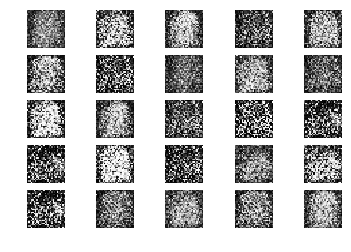

201 [D loss: 0.361857, acc.: 82.81%] [G loss: 2.567967]
202 [D loss: 0.404005, acc.: 79.69%] [G loss: 2.751624]
203 [D loss: 0.580872, acc.: 68.75%] [G loss: 2.008438]
204 [D loss: 0.265395, acc.: 90.62%] [G loss: 2.623390]
205 [D loss: 0.236900, acc.: 90.62%] [G loss: 2.841148]
206 [D loss: 0.398534, acc.: 82.81%] [G loss: 2.200915]
207 [D loss: 0.457805, acc.: 76.56%] [G loss: 2.708143]
208 [D loss: 0.326550, acc.: 89.06%] [G loss: 2.518660]
209 [D loss: 0.481432, acc.: 82.81%] [G loss: 2.273699]
210 [D loss: 0.301033, acc.: 90.62%] [G loss: 2.767855]
211 [D loss: 0.586079, acc.: 70.31%] [G loss: 2.266085]
212 [D loss: 0.280066, acc.: 87.50%] [G loss: 2.605839]
213 [D loss: 0.763957, acc.: 59.38%] [G loss: 2.479688]
214 [D loss: 0.300868, acc.: 89.06%] [G loss: 2.752598]
215 [D loss: 0.696507, acc.: 64.06%] [G loss: 2.259538]
216 [D loss: 0.417442, acc.: 82.81%] [G loss: 2.803970]
217 [D loss: 0.475840, acc.: 75.00%] [G loss: 2.538672]
218 [D loss: 0.382102, acc.: 84.38%] [G loss: 2.

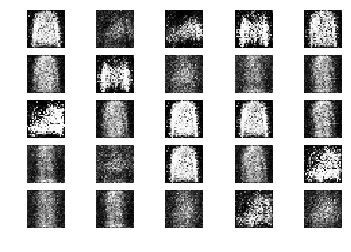

401 [D loss: 0.631746, acc.: 60.94%] [G loss: 0.830788]
402 [D loss: 0.667098, acc.: 60.94%] [G loss: 0.835595]
403 [D loss: 0.743417, acc.: 48.44%] [G loss: 0.760086]
404 [D loss: 0.684774, acc.: 59.38%] [G loss: 0.812449]
405 [D loss: 0.661319, acc.: 57.81%] [G loss: 0.812098]
406 [D loss: 0.655427, acc.: 64.06%] [G loss: 0.823842]
407 [D loss: 0.767137, acc.: 48.44%] [G loss: 0.805657]
408 [D loss: 0.673359, acc.: 50.00%] [G loss: 0.789182]
409 [D loss: 0.626666, acc.: 67.19%] [G loss: 0.850449]
410 [D loss: 0.679728, acc.: 53.12%] [G loss: 0.834791]
411 [D loss: 0.736099, acc.: 42.19%] [G loss: 0.814164]
412 [D loss: 0.699476, acc.: 48.44%] [G loss: 0.795351]
413 [D loss: 0.679153, acc.: 53.12%] [G loss: 0.795954]
414 [D loss: 0.661238, acc.: 57.81%] [G loss: 0.832192]
415 [D loss: 0.666735, acc.: 57.81%] [G loss: 0.793646]
416 [D loss: 0.655274, acc.: 62.50%] [G loss: 0.859322]
417 [D loss: 0.607075, acc.: 65.62%] [G loss: 0.877997]
418 [D loss: 0.735316, acc.: 54.69%] [G loss: 0.

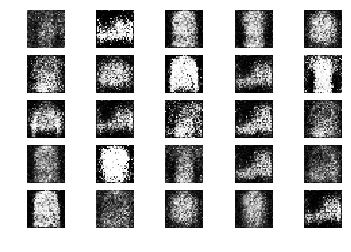

601 [D loss: 0.636586, acc.: 64.06%] [G loss: 0.790613]
602 [D loss: 0.594075, acc.: 67.19%] [G loss: 0.761638]
603 [D loss: 0.635870, acc.: 59.38%] [G loss: 0.838199]
604 [D loss: 0.581974, acc.: 64.06%] [G loss: 0.828303]
605 [D loss: 0.645402, acc.: 51.56%] [G loss: 0.861536]
606 [D loss: 0.612232, acc.: 65.62%] [G loss: 0.880855]
607 [D loss: 0.608979, acc.: 62.50%] [G loss: 0.864779]
608 [D loss: 0.611113, acc.: 67.19%] [G loss: 0.887663]
609 [D loss: 0.631868, acc.: 62.50%] [G loss: 0.890437]
610 [D loss: 0.632785, acc.: 57.81%] [G loss: 0.848429]
611 [D loss: 0.711434, acc.: 51.56%] [G loss: 0.843722]
612 [D loss: 0.669397, acc.: 67.19%] [G loss: 0.809283]
613 [D loss: 0.657312, acc.: 65.62%] [G loss: 0.817239]
614 [D loss: 0.637943, acc.: 65.62%] [G loss: 0.802205]
615 [D loss: 0.604564, acc.: 71.88%] [G loss: 0.840702]
616 [D loss: 0.640004, acc.: 59.38%] [G loss: 0.860903]
617 [D loss: 0.629545, acc.: 60.94%] [G loss: 0.849754]
618 [D loss: 0.680620, acc.: 50.00%] [G loss: 0.

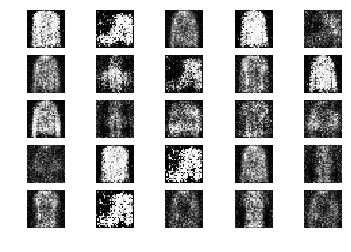

801 [D loss: 0.644153, acc.: 60.94%] [G loss: 0.860151]
802 [D loss: 0.598148, acc.: 71.88%] [G loss: 0.839222]
803 [D loss: 0.663503, acc.: 60.94%] [G loss: 0.771812]
804 [D loss: 0.660637, acc.: 67.19%] [G loss: 0.847028]
805 [D loss: 0.698578, acc.: 51.56%] [G loss: 0.802048]
806 [D loss: 0.612620, acc.: 65.62%] [G loss: 0.816647]
807 [D loss: 0.610194, acc.: 60.94%] [G loss: 0.784740]
808 [D loss: 0.637743, acc.: 64.06%] [G loss: 0.806630]
809 [D loss: 0.647195, acc.: 65.62%] [G loss: 0.797641]
810 [D loss: 0.604181, acc.: 68.75%] [G loss: 0.837436]
811 [D loss: 0.648371, acc.: 53.12%] [G loss: 0.851905]
812 [D loss: 0.645358, acc.: 59.38%] [G loss: 0.826622]
813 [D loss: 0.637244, acc.: 59.38%] [G loss: 0.873288]
814 [D loss: 0.654194, acc.: 57.81%] [G loss: 0.837738]
815 [D loss: 0.678773, acc.: 54.69%] [G loss: 0.819977]
816 [D loss: 0.629035, acc.: 71.88%] [G loss: 0.874978]
817 [D loss: 0.642463, acc.: 65.62%] [G loss: 0.850162]
818 [D loss: 0.733287, acc.: 54.69%] [G loss: 0.

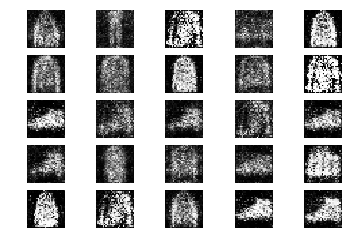

1001 [D loss: 0.682308, acc.: 62.50%] [G loss: 0.782510]
1002 [D loss: 0.649669, acc.: 67.19%] [G loss: 0.865333]
1003 [D loss: 0.662053, acc.: 60.94%] [G loss: 0.864425]
1004 [D loss: 0.689830, acc.: 51.56%] [G loss: 0.870766]
1005 [D loss: 0.648647, acc.: 59.38%] [G loss: 0.864412]
1006 [D loss: 0.690415, acc.: 53.12%] [G loss: 0.825888]
1007 [D loss: 0.648279, acc.: 60.94%] [G loss: 0.803916]
1008 [D loss: 0.631234, acc.: 62.50%] [G loss: 0.793859]
1009 [D loss: 0.662888, acc.: 56.25%] [G loss: 0.827509]
1010 [D loss: 0.613358, acc.: 59.38%] [G loss: 0.785214]
1011 [D loss: 0.577869, acc.: 71.88%] [G loss: 0.812153]
1012 [D loss: 0.531754, acc.: 78.12%] [G loss: 0.876848]
1013 [D loss: 0.665785, acc.: 60.94%] [G loss: 0.798399]
1014 [D loss: 0.725742, acc.: 54.69%] [G loss: 0.803064]
1015 [D loss: 0.707248, acc.: 59.38%] [G loss: 0.824578]
1016 [D loss: 0.645529, acc.: 65.62%] [G loss: 0.847216]
1017 [D loss: 0.651104, acc.: 57.81%] [G loss: 0.795453]
1018 [D loss: 0.667963, acc.: 6

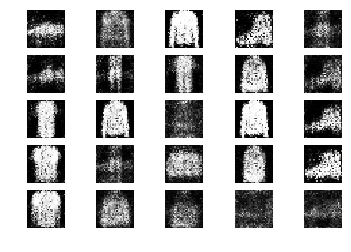

1201 [D loss: 0.665507, acc.: 57.81%] [G loss: 0.768042]
1202 [D loss: 0.625833, acc.: 64.06%] [G loss: 0.840202]
1203 [D loss: 0.643216, acc.: 64.06%] [G loss: 0.779514]
1204 [D loss: 0.659477, acc.: 64.06%] [G loss: 0.753847]
1205 [D loss: 0.719023, acc.: 45.31%] [G loss: 0.769597]
1206 [D loss: 0.627369, acc.: 71.88%] [G loss: 0.774233]
1207 [D loss: 0.638867, acc.: 67.19%] [G loss: 0.783220]
1208 [D loss: 0.627853, acc.: 70.31%] [G loss: 0.826333]
1209 [D loss: 0.664375, acc.: 57.81%] [G loss: 0.826035]
1210 [D loss: 0.648588, acc.: 59.38%] [G loss: 0.869360]
1211 [D loss: 0.682280, acc.: 57.81%] [G loss: 0.771107]
1212 [D loss: 0.632887, acc.: 62.50%] [G loss: 0.827663]
1213 [D loss: 0.637817, acc.: 65.62%] [G loss: 0.811220]
1214 [D loss: 0.670159, acc.: 54.69%] [G loss: 0.759100]
1215 [D loss: 0.679128, acc.: 59.38%] [G loss: 0.777233]
1216 [D loss: 0.725426, acc.: 50.00%] [G loss: 0.829286]
1217 [D loss: 0.664300, acc.: 57.81%] [G loss: 0.800728]
1218 [D loss: 0.662406, acc.: 5

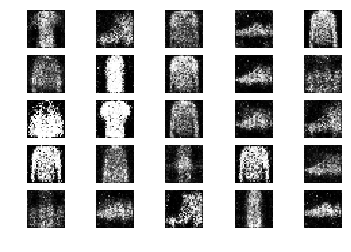

1401 [D loss: 0.634774, acc.: 70.31%] [G loss: 0.800163]
1402 [D loss: 0.640156, acc.: 65.62%] [G loss: 0.779350]
1403 [D loss: 0.694206, acc.: 53.12%] [G loss: 0.822147]
1404 [D loss: 0.642539, acc.: 62.50%] [G loss: 0.829663]
1405 [D loss: 0.675039, acc.: 64.06%] [G loss: 0.833603]
1406 [D loss: 0.643980, acc.: 65.62%] [G loss: 0.833714]
1407 [D loss: 0.665507, acc.: 60.94%] [G loss: 0.773842]
1408 [D loss: 0.704271, acc.: 48.44%] [G loss: 0.805962]
1409 [D loss: 0.625789, acc.: 68.75%] [G loss: 0.851107]
1410 [D loss: 0.705814, acc.: 51.56%] [G loss: 0.819619]
1411 [D loss: 0.645196, acc.: 67.19%] [G loss: 0.840191]
1412 [D loss: 0.659347, acc.: 59.38%] [G loss: 0.806300]
1413 [D loss: 0.677193, acc.: 59.38%] [G loss: 0.860243]
1414 [D loss: 0.656018, acc.: 57.81%] [G loss: 0.813560]
1415 [D loss: 0.647225, acc.: 64.06%] [G loss: 0.770413]
1416 [D loss: 0.666105, acc.: 60.94%] [G loss: 0.780978]
1417 [D loss: 0.686991, acc.: 46.88%] [G loss: 0.845245]
1418 [D loss: 0.620102, acc.: 6

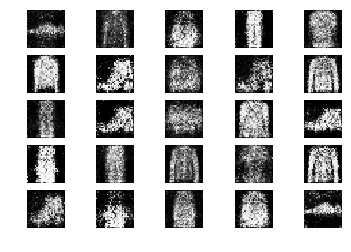

1601 [D loss: 0.731018, acc.: 51.56%] [G loss: 0.826623]
1602 [D loss: 0.652946, acc.: 62.50%] [G loss: 0.746397]
1603 [D loss: 0.598143, acc.: 76.56%] [G loss: 0.780953]
1604 [D loss: 0.680974, acc.: 57.81%] [G loss: 0.789218]
1605 [D loss: 0.679835, acc.: 57.81%] [G loss: 0.806876]
1606 [D loss: 0.679433, acc.: 57.81%] [G loss: 0.753149]
1607 [D loss: 0.664831, acc.: 54.69%] [G loss: 0.770468]
1608 [D loss: 0.671191, acc.: 60.94%] [G loss: 0.826868]
1609 [D loss: 0.686056, acc.: 59.38%] [G loss: 0.795953]
1610 [D loss: 0.645632, acc.: 60.94%] [G loss: 0.864956]
1611 [D loss: 0.655428, acc.: 59.38%] [G loss: 0.798001]
1612 [D loss: 0.652730, acc.: 54.69%] [G loss: 0.844040]
1613 [D loss: 0.647298, acc.: 64.06%] [G loss: 0.833112]
1614 [D loss: 0.674185, acc.: 53.12%] [G loss: 0.863048]
1615 [D loss: 0.667933, acc.: 57.81%] [G loss: 0.816432]
1616 [D loss: 0.690579, acc.: 48.44%] [G loss: 0.779843]
1617 [D loss: 0.653120, acc.: 59.38%] [G loss: 0.806970]
1618 [D loss: 0.663136, acc.: 5

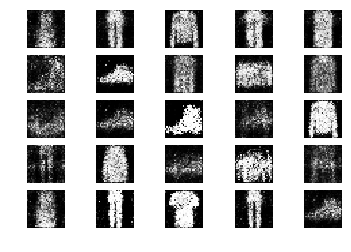

1801 [D loss: 0.641563, acc.: 60.94%] [G loss: 0.829360]
1802 [D loss: 0.671096, acc.: 56.25%] [G loss: 0.720559]
1803 [D loss: 0.687561, acc.: 57.81%] [G loss: 0.739498]
1804 [D loss: 0.713886, acc.: 54.69%] [G loss: 0.780148]
1805 [D loss: 0.656703, acc.: 62.50%] [G loss: 0.788687]
1806 [D loss: 0.652148, acc.: 56.25%] [G loss: 0.865416]
1807 [D loss: 0.695531, acc.: 54.69%] [G loss: 0.853552]
1808 [D loss: 0.671941, acc.: 53.12%] [G loss: 0.898670]
1809 [D loss: 0.679119, acc.: 60.94%] [G loss: 0.858897]
1810 [D loss: 0.665384, acc.: 48.44%] [G loss: 0.859866]
1811 [D loss: 0.656885, acc.: 64.06%] [G loss: 0.871904]
1812 [D loss: 0.659799, acc.: 64.06%] [G loss: 0.888095]
1813 [D loss: 0.666350, acc.: 48.44%] [G loss: 0.904910]
1814 [D loss: 0.670179, acc.: 65.62%] [G loss: 0.837717]
1815 [D loss: 0.649596, acc.: 57.81%] [G loss: 0.854135]
1816 [D loss: 0.640692, acc.: 62.50%] [G loss: 0.802007]
1817 [D loss: 0.651234, acc.: 57.81%] [G loss: 0.837374]
1818 [D loss: 0.654331, acc.: 5

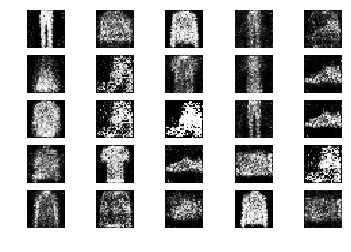

2001 [D loss: 0.672285, acc.: 56.25%] [G loss: 0.833890]
2002 [D loss: 0.678071, acc.: 56.25%] [G loss: 0.853585]
2003 [D loss: 0.635956, acc.: 62.50%] [G loss: 0.804016]
2004 [D loss: 0.653902, acc.: 64.06%] [G loss: 0.814143]
2005 [D loss: 0.696066, acc.: 48.44%] [G loss: 0.824735]
2006 [D loss: 0.676958, acc.: 60.94%] [G loss: 0.846603]
2007 [D loss: 0.646947, acc.: 60.94%] [G loss: 0.874617]
2008 [D loss: 0.669612, acc.: 56.25%] [G loss: 0.810354]
2009 [D loss: 0.673384, acc.: 54.69%] [G loss: 0.773413]
2010 [D loss: 0.691202, acc.: 50.00%] [G loss: 0.796115]
2011 [D loss: 0.620071, acc.: 67.19%] [G loss: 0.811786]
2012 [D loss: 0.677919, acc.: 54.69%] [G loss: 0.791211]
2013 [D loss: 0.644668, acc.: 62.50%] [G loss: 0.811855]
2014 [D loss: 0.682324, acc.: 60.94%] [G loss: 0.797320]
2015 [D loss: 0.665141, acc.: 67.19%] [G loss: 0.820135]
2016 [D loss: 0.676973, acc.: 60.94%] [G loss: 0.788745]
2017 [D loss: 0.626601, acc.: 62.50%] [G loss: 0.825548]
2018 [D loss: 0.657006, acc.: 6

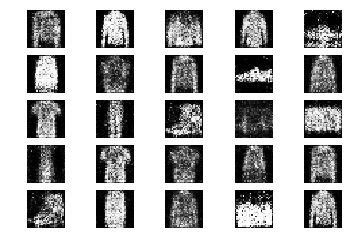

2201 [D loss: 0.647397, acc.: 59.38%] [G loss: 0.825565]
2202 [D loss: 0.660403, acc.: 65.62%] [G loss: 0.812204]
2203 [D loss: 0.667328, acc.: 64.06%] [G loss: 0.775852]
2204 [D loss: 0.713243, acc.: 51.56%] [G loss: 0.813368]
2205 [D loss: 0.675233, acc.: 65.62%] [G loss: 0.805091]
2206 [D loss: 0.688107, acc.: 56.25%] [G loss: 0.788657]
2207 [D loss: 0.660729, acc.: 60.94%] [G loss: 0.827784]
2208 [D loss: 0.652050, acc.: 65.62%] [G loss: 0.813480]
2209 [D loss: 0.656674, acc.: 60.94%] [G loss: 0.785945]
2210 [D loss: 0.755433, acc.: 45.31%] [G loss: 0.810776]
2211 [D loss: 0.655859, acc.: 57.81%] [G loss: 0.864217]
2212 [D loss: 0.659577, acc.: 64.06%] [G loss: 0.848632]
2213 [D loss: 0.676628, acc.: 57.81%] [G loss: 0.802538]
2214 [D loss: 0.643876, acc.: 64.06%] [G loss: 0.841837]
2215 [D loss: 0.686893, acc.: 53.12%] [G loss: 0.831253]
2216 [D loss: 0.644143, acc.: 70.31%] [G loss: 0.817925]
2217 [D loss: 0.718312, acc.: 43.75%] [G loss: 0.753355]
2218 [D loss: 0.662751, acc.: 6

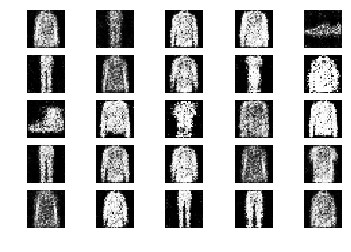

2401 [D loss: 0.657147, acc.: 57.81%] [G loss: 0.855155]
2402 [D loss: 0.652068, acc.: 64.06%] [G loss: 0.845600]
2403 [D loss: 0.707231, acc.: 48.44%] [G loss: 0.830782]
2404 [D loss: 0.662667, acc.: 54.69%] [G loss: 0.788910]
2405 [D loss: 0.651712, acc.: 56.25%] [G loss: 0.801719]
2406 [D loss: 0.725605, acc.: 50.00%] [G loss: 0.865276]
2407 [D loss: 0.702834, acc.: 60.94%] [G loss: 0.840480]
2408 [D loss: 0.622995, acc.: 68.75%] [G loss: 0.834411]
2409 [D loss: 0.658296, acc.: 60.94%] [G loss: 0.837875]
2410 [D loss: 0.674692, acc.: 57.81%] [G loss: 0.836000]
2411 [D loss: 0.647312, acc.: 60.94%] [G loss: 0.821290]
2412 [D loss: 0.696569, acc.: 56.25%] [G loss: 0.822663]
2413 [D loss: 0.669501, acc.: 60.94%] [G loss: 0.814894]
2414 [D loss: 0.620227, acc.: 62.50%] [G loss: 0.780148]
2415 [D loss: 0.659540, acc.: 54.69%] [G loss: 0.806844]
2416 [D loss: 0.709522, acc.: 48.44%] [G loss: 0.781945]
2417 [D loss: 0.658947, acc.: 64.06%] [G loss: 0.818866]
2418 [D loss: 0.633877, acc.: 6

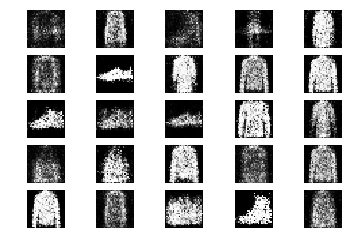

2601 [D loss: 0.684931, acc.: 57.81%] [G loss: 0.809465]
2602 [D loss: 0.657490, acc.: 59.38%] [G loss: 0.759263]
2603 [D loss: 0.689774, acc.: 53.12%] [G loss: 0.807773]
2604 [D loss: 0.689595, acc.: 53.12%] [G loss: 0.805443]
2605 [D loss: 0.710096, acc.: 46.88%] [G loss: 0.781907]
2606 [D loss: 0.672897, acc.: 57.81%] [G loss: 0.772252]
2607 [D loss: 0.626742, acc.: 70.31%] [G loss: 0.879384]
2608 [D loss: 0.637129, acc.: 62.50%] [G loss: 0.806873]
2609 [D loss: 0.641953, acc.: 70.31%] [G loss: 0.820334]
2610 [D loss: 0.675240, acc.: 57.81%] [G loss: 0.830649]
2611 [D loss: 0.736305, acc.: 46.88%] [G loss: 0.868044]
2612 [D loss: 0.677856, acc.: 57.81%] [G loss: 0.838971]
2613 [D loss: 0.693582, acc.: 48.44%] [G loss: 0.869683]
2614 [D loss: 0.700853, acc.: 51.56%] [G loss: 0.817157]
2615 [D loss: 0.685712, acc.: 56.25%] [G loss: 0.786198]
2616 [D loss: 0.673138, acc.: 62.50%] [G loss: 0.852339]
2617 [D loss: 0.714053, acc.: 57.81%] [G loss: 0.807755]
2618 [D loss: 0.675109, acc.: 5

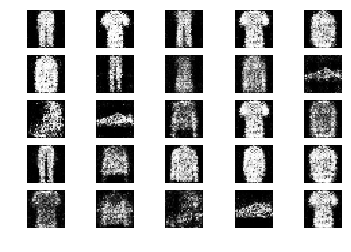

2801 [D loss: 0.684875, acc.: 60.94%] [G loss: 0.843991]
2802 [D loss: 0.663221, acc.: 57.81%] [G loss: 0.863441]
2803 [D loss: 0.709656, acc.: 54.69%] [G loss: 0.871624]
2804 [D loss: 0.641557, acc.: 68.75%] [G loss: 0.836503]
2805 [D loss: 0.681038, acc.: 54.69%] [G loss: 0.776169]
2806 [D loss: 0.674332, acc.: 59.38%] [G loss: 0.819829]
2807 [D loss: 0.671328, acc.: 60.94%] [G loss: 0.767340]
2808 [D loss: 0.703617, acc.: 62.50%] [G loss: 0.832411]
2809 [D loss: 0.724477, acc.: 42.19%] [G loss: 0.845819]
2810 [D loss: 0.671469, acc.: 62.50%] [G loss: 0.824780]
2811 [D loss: 0.688757, acc.: 54.69%] [G loss: 0.831340]
2812 [D loss: 0.661169, acc.: 60.94%] [G loss: 0.818653]
2813 [D loss: 0.716530, acc.: 45.31%] [G loss: 0.845426]
2814 [D loss: 0.652291, acc.: 65.62%] [G loss: 0.787636]
2815 [D loss: 0.684620, acc.: 53.12%] [G loss: 0.841617]
2816 [D loss: 0.659489, acc.: 60.94%] [G loss: 0.810227]
2817 [D loss: 0.664463, acc.: 62.50%] [G loss: 0.854973]
2818 [D loss: 0.604676, acc.: 6

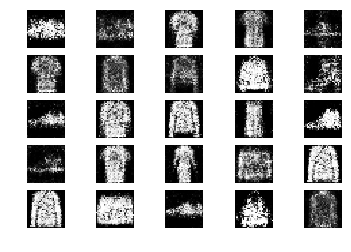

3001 [D loss: 0.681879, acc.: 54.69%] [G loss: 0.872371]
3002 [D loss: 0.651160, acc.: 67.19%] [G loss: 0.888152]
3003 [D loss: 0.639570, acc.: 67.19%] [G loss: 0.880485]
3004 [D loss: 0.698158, acc.: 59.38%] [G loss: 0.810696]
3005 [D loss: 0.701687, acc.: 54.69%] [G loss: 0.829480]
3006 [D loss: 0.650594, acc.: 60.94%] [G loss: 0.830607]
3007 [D loss: 0.689449, acc.: 53.12%] [G loss: 0.826131]
3008 [D loss: 0.670129, acc.: 56.25%] [G loss: 0.809111]
3009 [D loss: 0.673893, acc.: 50.00%] [G loss: 0.850366]
3010 [D loss: 0.653642, acc.: 67.19%] [G loss: 0.870944]
3011 [D loss: 0.634979, acc.: 68.75%] [G loss: 0.823296]
3012 [D loss: 0.652827, acc.: 62.50%] [G loss: 0.812097]
3013 [D loss: 0.658214, acc.: 65.62%] [G loss: 0.783680]
3014 [D loss: 0.683904, acc.: 60.94%] [G loss: 0.846782]
3015 [D loss: 0.614076, acc.: 73.44%] [G loss: 0.832470]
3016 [D loss: 0.703459, acc.: 57.81%] [G loss: 0.858309]
3017 [D loss: 0.689655, acc.: 50.00%] [G loss: 0.846737]
3018 [D loss: 0.707531, acc.: 5

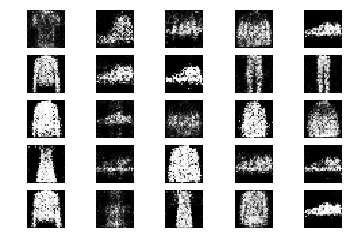

3201 [D loss: 0.681623, acc.: 54.69%] [G loss: 0.853471]
3202 [D loss: 0.690311, acc.: 56.25%] [G loss: 0.843523]
3203 [D loss: 0.655300, acc.: 62.50%] [G loss: 0.841403]
3204 [D loss: 0.653231, acc.: 60.94%] [G loss: 0.862752]
3205 [D loss: 0.746404, acc.: 42.19%] [G loss: 0.845040]
3206 [D loss: 0.651820, acc.: 65.62%] [G loss: 0.835186]
3207 [D loss: 0.630229, acc.: 70.31%] [G loss: 0.862023]
3208 [D loss: 0.655858, acc.: 60.94%] [G loss: 0.856130]
3209 [D loss: 0.609938, acc.: 67.19%] [G loss: 0.832302]
3210 [D loss: 0.673356, acc.: 59.38%] [G loss: 0.799255]
3211 [D loss: 0.701952, acc.: 57.81%] [G loss: 0.819468]
3212 [D loss: 0.694673, acc.: 51.56%] [G loss: 0.793783]
3213 [D loss: 0.664194, acc.: 54.69%] [G loss: 0.849174]
3214 [D loss: 0.702938, acc.: 51.56%] [G loss: 0.866359]
3215 [D loss: 0.614996, acc.: 65.62%] [G loss: 0.929014]
3216 [D loss: 0.683857, acc.: 59.38%] [G loss: 0.883783]
3217 [D loss: 0.773959, acc.: 48.44%] [G loss: 0.906129]
3218 [D loss: 0.697032, acc.: 5

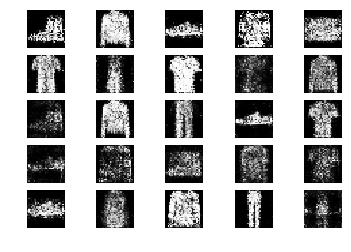

3401 [D loss: 0.654458, acc.: 57.81%] [G loss: 0.801158]
3402 [D loss: 0.651051, acc.: 67.19%] [G loss: 0.866230]
3403 [D loss: 0.748032, acc.: 48.44%] [G loss: 0.805794]
3404 [D loss: 0.694519, acc.: 54.69%] [G loss: 0.823516]
3405 [D loss: 0.681786, acc.: 56.25%] [G loss: 0.851790]
3406 [D loss: 0.683375, acc.: 51.56%] [G loss: 0.798801]
3407 [D loss: 0.686943, acc.: 50.00%] [G loss: 0.879521]
3408 [D loss: 0.653351, acc.: 60.94%] [G loss: 0.872503]
3409 [D loss: 0.712367, acc.: 43.75%] [G loss: 0.865248]
3410 [D loss: 0.651553, acc.: 51.56%] [G loss: 0.940454]
3411 [D loss: 0.688969, acc.: 51.56%] [G loss: 0.897462]
3412 [D loss: 0.687450, acc.: 54.69%] [G loss: 0.897617]
3413 [D loss: 0.673373, acc.: 65.62%] [G loss: 0.838956]
3414 [D loss: 0.655802, acc.: 67.19%] [G loss: 0.797876]
3415 [D loss: 0.701351, acc.: 51.56%] [G loss: 0.857003]
3416 [D loss: 0.652283, acc.: 59.38%] [G loss: 0.794100]
3417 [D loss: 0.687280, acc.: 56.25%] [G loss: 0.844872]
3418 [D loss: 0.704998, acc.: 5

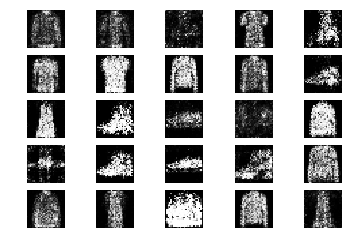

3601 [D loss: 0.643587, acc.: 59.38%] [G loss: 0.861394]
3602 [D loss: 0.666104, acc.: 60.94%] [G loss: 0.814844]
3603 [D loss: 0.696123, acc.: 54.69%] [G loss: 0.796395]
3604 [D loss: 0.688416, acc.: 50.00%] [G loss: 0.803151]
3605 [D loss: 0.644488, acc.: 64.06%] [G loss: 0.789102]
3606 [D loss: 0.708660, acc.: 53.12%] [G loss: 0.770624]
3607 [D loss: 0.681712, acc.: 53.12%] [G loss: 0.818385]
3608 [D loss: 0.641092, acc.: 65.62%] [G loss: 0.846164]
3609 [D loss: 0.691738, acc.: 57.81%] [G loss: 0.826797]
3610 [D loss: 0.626796, acc.: 71.88%] [G loss: 0.853214]
3611 [D loss: 0.677707, acc.: 59.38%] [G loss: 0.840400]
3612 [D loss: 0.683576, acc.: 56.25%] [G loss: 0.793827]
3613 [D loss: 0.663496, acc.: 57.81%] [G loss: 0.883140]
3614 [D loss: 0.681313, acc.: 45.31%] [G loss: 0.801875]
3615 [D loss: 0.701752, acc.: 51.56%] [G loss: 0.871325]
3616 [D loss: 0.681542, acc.: 57.81%] [G loss: 0.860639]
3617 [D loss: 0.641835, acc.: 65.62%] [G loss: 0.943882]
3618 [D loss: 0.681540, acc.: 5

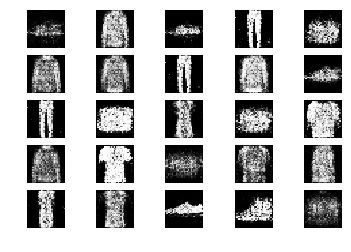

3801 [D loss: 0.669549, acc.: 56.25%] [G loss: 0.805386]
3802 [D loss: 0.607639, acc.: 75.00%] [G loss: 0.870172]
3803 [D loss: 0.698243, acc.: 59.38%] [G loss: 0.845404]
3804 [D loss: 0.681035, acc.: 57.81%] [G loss: 0.804770]
3805 [D loss: 0.659839, acc.: 62.50%] [G loss: 0.823691]
3806 [D loss: 0.649827, acc.: 59.38%] [G loss: 0.846628]
3807 [D loss: 0.690905, acc.: 60.94%] [G loss: 0.827246]
3808 [D loss: 0.625241, acc.: 70.31%] [G loss: 0.788954]
3809 [D loss: 0.658807, acc.: 57.81%] [G loss: 0.827473]
3810 [D loss: 0.656472, acc.: 64.06%] [G loss: 0.878761]
3811 [D loss: 0.666541, acc.: 51.56%] [G loss: 0.827858]
3812 [D loss: 0.704278, acc.: 54.69%] [G loss: 0.799576]
3813 [D loss: 0.650516, acc.: 68.75%] [G loss: 0.807493]
3814 [D loss: 0.654730, acc.: 54.69%] [G loss: 0.814548]
3815 [D loss: 0.711061, acc.: 57.81%] [G loss: 0.840587]
3816 [D loss: 0.694985, acc.: 60.94%] [G loss: 0.787246]
3817 [D loss: 0.674995, acc.: 54.69%] [G loss: 0.774254]
3818 [D loss: 0.661260, acc.: 5

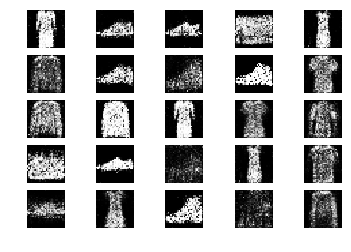

4001 [D loss: 0.637981, acc.: 62.50%] [G loss: 0.813904]
4002 [D loss: 0.635531, acc.: 62.50%] [G loss: 0.841760]
4003 [D loss: 0.685233, acc.: 53.12%] [G loss: 0.814367]
4004 [D loss: 0.642241, acc.: 62.50%] [G loss: 0.822307]
4005 [D loss: 0.640255, acc.: 67.19%] [G loss: 0.791276]
4006 [D loss: 0.659730, acc.: 60.94%] [G loss: 0.898292]
4007 [D loss: 0.605709, acc.: 71.88%] [G loss: 0.817762]
4008 [D loss: 0.703954, acc.: 60.94%] [G loss: 0.861486]
4009 [D loss: 0.739964, acc.: 45.31%] [G loss: 0.867461]
4010 [D loss: 0.647449, acc.: 62.50%] [G loss: 0.842633]
4011 [D loss: 0.700855, acc.: 53.12%] [G loss: 0.812179]
4012 [D loss: 0.671055, acc.: 57.81%] [G loss: 0.821218]
4013 [D loss: 0.675504, acc.: 51.56%] [G loss: 0.806045]
4014 [D loss: 0.626837, acc.: 57.81%] [G loss: 0.863618]
4015 [D loss: 0.714000, acc.: 54.69%] [G loss: 0.787220]
4016 [D loss: 0.647863, acc.: 54.69%] [G loss: 0.852807]
4017 [D loss: 0.660606, acc.: 65.62%] [G loss: 0.812531]
4018 [D loss: 0.650688, acc.: 5

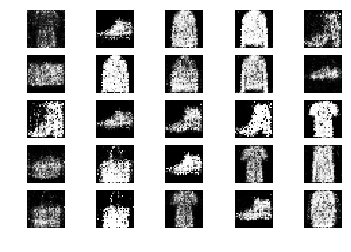

4201 [D loss: 0.694652, acc.: 50.00%] [G loss: 0.857034]
4202 [D loss: 0.689308, acc.: 65.62%] [G loss: 0.882052]
4203 [D loss: 0.671834, acc.: 68.75%] [G loss: 0.882641]
4204 [D loss: 0.683820, acc.: 51.56%] [G loss: 0.844396]
4205 [D loss: 0.687026, acc.: 53.12%] [G loss: 0.864999]
4206 [D loss: 0.675901, acc.: 59.38%] [G loss: 0.873438]
4207 [D loss: 0.691951, acc.: 54.69%] [G loss: 0.811552]
4208 [D loss: 0.643732, acc.: 59.38%] [G loss: 0.813726]
4209 [D loss: 0.704071, acc.: 50.00%] [G loss: 0.752391]
4210 [D loss: 0.671453, acc.: 64.06%] [G loss: 0.784253]
4211 [D loss: 0.715990, acc.: 48.44%] [G loss: 0.808157]
4212 [D loss: 0.699834, acc.: 57.81%] [G loss: 0.816922]
4213 [D loss: 0.692499, acc.: 53.12%] [G loss: 0.872131]
4214 [D loss: 0.705811, acc.: 48.44%] [G loss: 0.825067]
4215 [D loss: 0.669489, acc.: 56.25%] [G loss: 0.837304]
4216 [D loss: 0.637219, acc.: 59.38%] [G loss: 0.909014]
4217 [D loss: 0.661830, acc.: 60.94%] [G loss: 0.871140]
4218 [D loss: 0.629952, acc.: 7

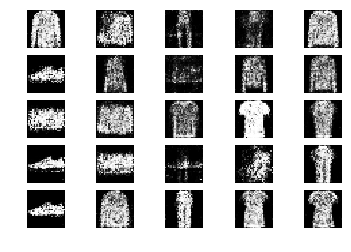

4401 [D loss: 0.712771, acc.: 54.69%] [G loss: 0.823065]
4402 [D loss: 0.674331, acc.: 59.38%] [G loss: 0.759634]
4403 [D loss: 0.671560, acc.: 57.81%] [G loss: 0.774341]
4404 [D loss: 0.727222, acc.: 48.44%] [G loss: 0.809241]
4405 [D loss: 0.676158, acc.: 54.69%] [G loss: 0.833202]
4406 [D loss: 0.682833, acc.: 53.12%] [G loss: 0.861394]
4407 [D loss: 0.737188, acc.: 50.00%] [G loss: 0.771786]
4408 [D loss: 0.642512, acc.: 64.06%] [G loss: 0.821405]
4409 [D loss: 0.712261, acc.: 45.31%] [G loss: 0.803897]
4410 [D loss: 0.653488, acc.: 56.25%] [G loss: 0.808686]
4411 [D loss: 0.689863, acc.: 56.25%] [G loss: 0.837561]
4412 [D loss: 0.721543, acc.: 46.88%] [G loss: 0.842841]
4413 [D loss: 0.651329, acc.: 62.50%] [G loss: 0.826795]
4414 [D loss: 0.718412, acc.: 48.44%] [G loss: 0.887909]
4415 [D loss: 0.672668, acc.: 56.25%] [G loss: 0.807099]
4416 [D loss: 0.680838, acc.: 54.69%] [G loss: 0.811388]
4417 [D loss: 0.633206, acc.: 62.50%] [G loss: 0.861445]
4418 [D loss: 0.659816, acc.: 6

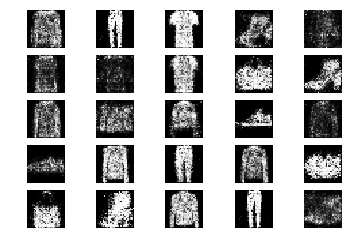

4601 [D loss: 0.673476, acc.: 62.50%] [G loss: 0.824585]
4602 [D loss: 0.694660, acc.: 50.00%] [G loss: 0.850062]
4603 [D loss: 0.710816, acc.: 56.25%] [G loss: 0.833233]
4604 [D loss: 0.680599, acc.: 57.81%] [G loss: 0.834723]
4605 [D loss: 0.702223, acc.: 56.25%] [G loss: 0.785563]
4606 [D loss: 0.729626, acc.: 46.88%] [G loss: 0.825336]
4607 [D loss: 0.720124, acc.: 40.62%] [G loss: 0.764887]
4608 [D loss: 0.649763, acc.: 56.25%] [G loss: 0.825831]
4609 [D loss: 0.705755, acc.: 54.69%] [G loss: 0.878302]
4610 [D loss: 0.671400, acc.: 53.12%] [G loss: 0.824704]
4611 [D loss: 0.679911, acc.: 62.50%] [G loss: 0.762141]
4612 [D loss: 0.696066, acc.: 56.25%] [G loss: 0.750237]
4613 [D loss: 0.781479, acc.: 45.31%] [G loss: 0.810085]
4614 [D loss: 0.691384, acc.: 56.25%] [G loss: 0.864725]
4615 [D loss: 0.692647, acc.: 56.25%] [G loss: 0.827256]
4616 [D loss: 0.717838, acc.: 50.00%] [G loss: 0.850702]
4617 [D loss: 0.718144, acc.: 56.25%] [G loss: 0.740835]
4618 [D loss: 0.657299, acc.: 6

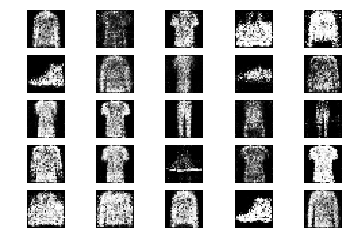

4801 [D loss: 0.683040, acc.: 56.25%] [G loss: 0.782074]
4802 [D loss: 0.645458, acc.: 73.44%] [G loss: 0.806604]
4803 [D loss: 0.669817, acc.: 57.81%] [G loss: 0.801785]
4804 [D loss: 0.699487, acc.: 51.56%] [G loss: 0.823210]
4805 [D loss: 0.683307, acc.: 53.12%] [G loss: 0.787772]
4806 [D loss: 0.656829, acc.: 59.38%] [G loss: 0.887212]
4807 [D loss: 0.689922, acc.: 56.25%] [G loss: 0.870018]
4808 [D loss: 0.630214, acc.: 57.81%] [G loss: 0.863115]
4809 [D loss: 0.725643, acc.: 48.44%] [G loss: 0.834994]
4810 [D loss: 0.672608, acc.: 54.69%] [G loss: 0.825750]
4811 [D loss: 0.631693, acc.: 68.75%] [G loss: 0.834809]
4812 [D loss: 0.705638, acc.: 51.56%] [G loss: 0.741439]
4813 [D loss: 0.720838, acc.: 50.00%] [G loss: 0.764465]
4814 [D loss: 0.683429, acc.: 51.56%] [G loss: 0.762568]
4815 [D loss: 0.708597, acc.: 56.25%] [G loss: 0.740589]
4816 [D loss: 0.637555, acc.: 67.19%] [G loss: 0.788912]
4817 [D loss: 0.709350, acc.: 54.69%] [G loss: 0.825176]
4818 [D loss: 0.684995, acc.: 5

In [7]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=5000, batch_size=32, sample_interval=200)